# Model quantization

If you plan on using this implementation, please cite our work (\url{https://www.sciencedirect.com/science/article/pii/S0141933119302844}):

@article{Nalepa2020MaM,
author = {Jakub Nalepa and Marek Antoniak and
Michal Myller and Pablo {Ribalta Lorenzo} and Michal Marcinkiewicz},
title = {Towards resource-frugal deep convolutional neural 
networks for hyperspectral image segmentation},
journal = {Microprocessors and Microsystems},
volume = {73},
pages = {102994},
year = {2020},
issn = {0141-9331},
doi = {https://doi.org/10.1016/j.micpro.2020.102994},
url = {https://www.sciencedirect.com/science/article/pii/S0141933119302844}}


To perform model quantization, we use the Xillinx DNNDK tool (https://www.xilinx.com/support/documentation/sw_manuals/ai_inference/v1_6/ug1327-dnndk-user-guide.pdf).

In [1]:
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

In [4]:
import os
import subprocess

import tensorflow as tf

from scripts.quantization import evaluate_graph, freeze_model
from scripts import prepare_data, artifacts_reporter, train_model, evaluate_model
from ml_intuition.data.utils import plot_training_curve, show_statistics

In [5]:
DEST_PATH = 'xillinx_model_compilation_results'
DATA_FILE_PATH = os.path.join(os.path.dirname(os.getcwd()), 'datasets/pavia/pavia.npy')
GT_FILE_PAT = os.path.join(os.path.dirname(os.getcwd()), 'datasets/pavia/pavia_gt.npy')
experiment_dest_path = os.path.join(DEST_PATH, 'experiment_0')
data_path = os.path.join(experiment_dest_path, 'data.h5')
os.makedirs(experiment_dest_path, exist_ok=True)

# Prepare the data

To fit into the the pipeline, the data has to be preprocessed. It is achieved by the `prepare_data.main` function. It accepts a path to a `.npy` file with the original cube as well as the corresponding ground truth.  In this example, we randomly extract 250 samples from each class (balanced scenario), use 10% of them as validation set, and extract only spectral information of a pixel. The returned object is a dictionary with three keys: `train`, `test` and `val`. Each of them contains an additional dictionary with `data` and `labels` keys, holding corresponding `numpy.ndarray` objects with the data. For more details about the parameters, refer to the documentation of `prepare_data.main` function (located in `scripts/prepare_data`).

In [6]:
prepare_data.main(data_file_path=DATA_FILE_PATH,
                            ground_truth_path=GT_FILE_PAT,
                            output_path=data_path,
                            train_size=250,
                            val_size=0.1,
                            stratified=True,
                            background_label=0,
                            channels_idx=2,
                            neighborhood_size=None,
                            save_data=True,
                            seed=0)

# Train the model

The function `trian_model.train` executed the trainig procedure. Trained model will be stored under `experiment_dest_path` folder path.

In [7]:
train_model.train(model_name='model_2d',
                    kernel_size=5,
                    n_kernels=200,
                    n_layers=1,
                    dest_path=experiment_dest_path,
                    data=data_path,
                    sample_size=103,
                    n_classes=9,
                    lr=0.001,
                    batch_size=128,
                    epochs=200,
                    verbose=0,
                    shuffle=True,
                    patience=15,
                    noise=[],
                    noise_sets=[])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 99, 1, 200)        1200      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 1, 200)        200200    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 1, 200)        200200    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 1, 200)         200200    
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 200)               200200    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               25728     
__________

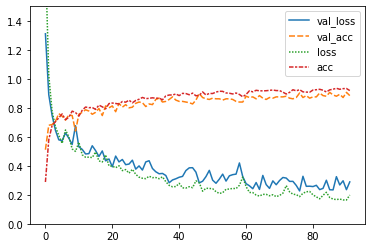

In [8]:
plot_training_curve(os.path.join(experiment_dest_path, "training_metrics.csv"), ['val_loss', 'val_acc', 'loss', 'acc'])

# Evaluate full precision model

Evaluate performance of the model in full precision to later compare to the quantized one.

In [ ]:
evaluate_model.evaluate(
    model_path=os.path.join(experiment_dest_path, 'model_2d'),
    data=data_path,
    dest_path=experiment_dest_path,
    n_classes=9,
    batch_size=1024,
    noise=[],
    noise_sets=[])
tf.keras.backend.clear_session()

In [10]:
show_statistics(os.path.join(experiment_dest_path, "inference_metrics.csv"))

,accuracy_score,balanced_accuracy_score,cohen_kappa_score,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,inference_time
0,0.842077,0.903612,0.795369,0.843755,0.783575,0.831801,0.964463,0.99726,0.903327,0.953704,0.856061,0.998565,7.275701


# Freeze model

Freeze the tensorflow model into the `.pb` format.

In [11]:
freeze_model.main(model_path=os.path.join(experiment_dest_path, 'model_2d'), 
                  output_dir=experiment_dest_path)

INFO:tensorflow:Froze 61 variables.
INFO:tensorflow:Converted 61 variables to const ops.
Frozen model saved at xillinx_model_compilation_results/experiment_0


# Quantize the model

Perform the quantization by running the `quantize.sh` bash script with appropriate parameters. It executes the `decent_q` command from the Xillinx DNNDK library. The output is the `quantize_eval_model.pb` file and a `deploy_model.pb` file, which should be used for compilation for a specific DPU.

In [12]:
node_names_file = os.path.join(experiment_dest_path, 'freeze_input_output_node_name.json')
frozen_graph_path = os.path.join(experiment_dest_path, 'frozen_graph.pb')
cmd = '../scripts/quantize.sh ' + node_names_file + ' ' \
        + frozen_graph_path + ' ' + data_path + ' ' + \
        '?,103,1,1' + ' ' + \
        'ml_intuition.data.input_fn.calibrate_2d_input' + ' ' + \
        '128' + ' ' + experiment_dest_path + \
        ' ' + str(0)
f = open(os.path.join(experiment_dest_path, 'call_output.txt'),'w')
env = os.environ.copy()
env['PYTHONPATH'] = os.path.dirname(os.getcwd())
subprocess.call(cmd, shell=True, env=env, stderr=f)
f.close()

# Evaluate the quantized model (graph)

Evaluate the performance of the quantized model to check whether there was any loss in performance. Results for the graph are stored in `inference_graph_metrics.csv`.

In [ ]:
graph_path = os.path.join(experiment_dest_path, 'quantize_eval_model.pb')
evaluate_graph.main(graph_path=graph_path,
                    node_names_path=node_names_file,
                    dataset_path=data_path,
                    batch_size=1024)
tf.keras.backend.clear_session()

In [14]:
show_statistics(os.path.join(experiment_dest_path, "inference_graph_metrics.csv"))

,accuracy_score,balanced_accuracy_score,cohen_kappa_score,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,inference_time
0,0.874402,0.888489,0.832185,0.908322,0.89119,0.868037,0.933547,0.998174,0.799121,0.887037,0.712413,0.998565,21.373184
